In [1]:
import tensorflow as tf
from __future__ import print_function
import numpy as np


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## A1 Q1
Euclidean distance function, vectorized    

In [2]:
def euclideanDistance(x, z):
    '''
    We vectorized the operation with matrix operations
    the ||x - z ||^2 is = Sum(x - z)^2 = Sum from 1 to D
    of (x^2 - 2xz + z^2)
    
    x^2 = x^T times x
    z^2 = z^T times z
    we can find the sum of each row by using the reduce sum function
    
    sum of -2xz 
    we can use matrix multiplication, x times z^T to obtain xz,
    then multiply by -2
    '''
    n1 = x.shape[0]
    n2 = z.shape[0]    
    
    x_squared = tf.square(x)
    z_squared = tf.square(z) #tf.matmul(z ,tf.transpose(z))
    #print("x_squared.eval()")
    #print(x_squared.eval())
    x_2_sum = tf.reduce_sum(x_squared, 1)
    z_2_sum = tf.reduce_sum(z_squared, 1)
    
    x_2_sum = tf.transpose(x_2_sum)
    z_2_sum = tf.transpose(z_2_sum)
    #x_2_sum = tf.reshape(x_2_sum, [-1, 1])
    #z_2_sum = tf.reshape(z_2_sum, [-1, 1])
    #print("x_2_sum.eval()")
    #print(x_2_sum.eval())
    
    xz = tf.matmul(x, tf.transpose(z))
    #print(xz.eval())
    minus_2xz = tf.scalar_mul(-2, xz)
    #print(minus_2xz.eval())
 
    x_2_tile =tf.tile(tf.expand_dims(x_2_sum, 1), [1, n2])
    z_2_tile = tf.tile(tf.expand_dims(z_2_sum ,1), [1, n1])
    z_2_tile_T = tf.transpose(z_2_tile)
    #print(x_2_tile.eval())
    #print(z_2_tile_T.eval())
    
    result = x_2_tile + minus_2xz +z_2_tile_T
    
    return result

"""VERIFIED"""

def testi():
    A = tf.constant([[1, 1], [2,2], [3, 3], [4,4]])
    B = tf.constant([[1, 1], [2, 2],[3,3]])
    res_mine = euclideanDistance(A, B)
    
    print("----my func----")
    print(res_mine.eval())
    print("---diff square---")
    res_lib = PairwiseDistances(A, B)
    print(res_lib.eval())
    

## A1 Q2
### part 1

| x1^T | x2^T | .... |
top k closest in x1^T indices are the neighbours


yˆ(x∗) = YTr∗, where r∗ = [r1,...,rN],rn = 1/k
0, otherwise.




In [3]:
#given starter code
import numpy as np
import matplotlib.pyplot as plt

# my code part1 responsibility
def nearestIndices(_dist_mat, _k):
    # with tf.Session() as sess:
    #_dist_mat = tf.constant([ [4, 9], [16, 25] ], tf.int32)
    print("our k value", _k)
    #print("dist mat shape", _dist_mat.shape)
    nearest_k_data, nearest_k_indices = tf.nn.top_k(tf.negative(_dist_mat), _k)
       
    #print(type(indices_arr))
    return nearest_k_data, nearest_k_indices


#unit testing
#dist_mat = tf.constant([ 4, 9, 16, 25 ], tf.int32)
#topk = nearestIndices(dist_mat, 2)
#responsibility(topk, 2, 4)



In [4]:
def pairDist(_data, _data1):
    #TODO: what if no library function
    data_t = tf.convert_to_tensor(_data)
    data1_t = tf.convert_to_tensor(_data1)
    #data_t = tf.cast(data_t, tf.float16)
    #data1_t = tf.cast(data1_t, tf.float16)
    dist = euclideanDistance(data_t, data1_t)
    return dist
  

def knn(_trainData, _trainTarget, _new_data, _k):
    '''
    KNN using responsibility
    '''
    #nearest indices
    dist_mat = pairDist( _new_data, _trainData )    
    #dist_mat = tf.convert_to_tensor(dist_mat)
    nearest_k, nearest_k_idx = nearestIndices(dist_mat, _k)
    predict_res = tf.reduce_mean(tf.gather(_trainTarget, nearest_k_idx), 1)
    #print("predict", predict_res.eval())
    return predict_res



  

#pairDist(testData) 
#pred_result = knn(testData, testTarget, _k = 3)

In [5]:
def plotResult(_trainData, _trainTarget):
    X = np.linspace(0.0, 11.0, num = 100)[:, np.newaxis]
    xTensor = tf.stack(X)
    
    num_neighbour_list = [1, 3, 5, 50]
    for j in num_neighbour_list:
        print("plot result")
        dist_mat = pairDist( X, _trainData ) 
        nearest_k, nearest_k_idx = nearestIndices(dist_mat, j)
        predict_res = tf.reduce_mean(tf.gather(_trainTarget, nearest_k_idx), 1)

        plt.figure()#(j+100)
        plt.scatter(sessMain.run(_trainData), sessMain.run(_trainTarget))
        plt.title("K = " + str(j))
        plt.plot(sessMain.run(xTensor), sessMain.run(predict_res))
        
        fileName = str("KNN") + str(j) + str("trainingGraph.png")
        plt.savefig(fileName)


In [6]:
def testKValuesKNN(trainData, trainTarget, testData, testTarget):
    num_neighbour_list = [1, 3, 5, 50]
    loss_list = []

    for j in num_neighbour_list:
        print("j = ", j)
        y_hat = knn(trainData, trainTarget, testData,  j)
        #_y_hat = tf.transpose(_y_hat)
        #mse_mat = euclideanDistance(_y_hat, _y) 
      
        mse_mat = tf.square(tf.subtract(y_hat, testTarget))
        loss = tf.reduce_mean(mse_mat)/2.0
        print("neighbout = " ,j)
        loss_list.append(loss.eval())
    return loss_list
        

In [7]:
def q1():
    np.random.seed(521)
    Data = np.linspace(1.0 , 10.0 , num =100) [:, np. newaxis]
    Target = np.sin( Data ) + 0.1 * np.power( Data , 2) \
         + 0.5 * np.random.randn(100 , 1)
    randIdx = np.arange(100)
    np.random.shuffle(randIdx)
    trainData, trainTarget  = Data[randIdx[:80]], Target[randIdx[:80]]
    validData, validTarget = Data[randIdx[80:90]], Target[randIdx[80:90]]
    testData, testTarget = Data[randIdx[90:100]], Target[randIdx[90:100]]

    # convert numpy array to tensors
    trainData = tf.stack(trainData)
    trainTarget = tf.stack(trainTarget)
    testData = tf.stack(testData)
    testTarget = tf.stack(testTarget)
    validData = tf.stack(validData)
    validtarget = tf.stack(validTarget)
    
    plotResult(trainData, trainTarget)
    
    loss_test = testKValuesKNN(trainData, trainTarget, testData, testTarget)
    print("loss_test", loss_test)
    
    loss_train = testKValuesKNN(trainData, trainTarget, trainData, trainTarget)
    print("loss_train" , loss_train)
    
    loss_valid = testKValuesKNN(trainData, trainTarget, validData, validTarget)
    print("loss_valid", loss_valid)

## Loss on Q1 KNN

|k | 1 | 3 | 5| 50|
|------|------|-----|-----|
|test | 0.12799977712101845 | 0.14242504248546536 | 0.18633105926605592 | 0.70693467047889302 |
|train | 0.0 | 0.10825207710580038 | 0.12183845521874122 | 1.2477892734500411 |
|valid | 0.28807977607463453 | 0.30897640431136369 | 0.31043863052707066 | 1.2230445257949047 |

In [8]:
def data_segmentation(data_path, target_path, task):
    # task = 0 >> select the name ID targets for face recognition task
    # task = 1 >> select the gender ID targets for gender recognition task data = np.load(data_path)/255
    data = np.load(data_path)/255
    data = np.reshape(data, [-1, 32*32])
    target = np.load(target_path)
    np.random.seed(45689)
    rnd_idx = np.arange(np.shape(data)[0])
    np.random.shuffle(rnd_idx)
    trBatch = int(0.8*len(rnd_idx))
    validBatch = int(0.1*len(rnd_idx))
    trainData, validData, testData = data[rnd_idx[1:trBatch],:], \
                                   data[rnd_idx[trBatch+1:trBatch + validBatch],:],\
                                   data[rnd_idx[trBatch + validBatch+1:-1],:]
    trainTarget, validTarget, testTarget = target[rnd_idx[1:trBatch], task], \
                              target[rnd_idx[trBatch+1:trBatch + validBatch], task],\
                              target[rnd_idx[trBatch + validBatch + 1:-1], task]
    print("train data dim", trainData.shape, "valid data dim", validData.shape,
             "test data dim", testData.shape, "trainTarget shape", trainTarget.shape,
             "validTarget SHAPE", validTarget.shape, "testTarget shape", testTarget.shape)
    return trainData, validData, testData, trainTarget, validTarget, testTarget


In [9]:
dum_tensor = tf.constant(0)
def foo():
    return dum_tensor


def plot_k10(_test_img, _neighbour_img):
    test_img = _test_img.eval()
    print("test_img", test_img)
    test_img = np.reshape(test_img, [32, 32] )
    plt.imshow(test_img, cmap='gray')
    plt.title("Confusion image")
    plt.show()
    fileName = str("KNN") + str("confusedimg.png")
    plt.savefig(fileName)

    neighbour_img = _neighbour_img.eval()
    print("neighbour", neighbour_img.shape)
    n_count = neighbour_img.shape[1] 
    # i: index
    for i in range(n_count):
        #TODO: Plot feature i against y
        curr_img = np.reshape(neighbour_img[:,i], [32, 32] ) 
        plt.imshow(curr_img,  cmap='gray' )
        plt.title("Neighbours")
        plt.show()
        fileName = str("KNN") +str("neighbour") + str(i) + str(".png")
        plt.savefig(fileName)
    return dum_tensor

In [10]:
def knnVote(_trainData, _trainTarget, _new_data, _new_target, _k):
    '''
    KNN using majority vote
    '''
    #nearest indices
    dist_mat = pairDist( _new_data, _trainData ) 
    #print("in knn vote", dist_mat)
    
    nearest_k, nearest_k_idx = nearestIndices(dist_mat, _k)
    neighbours = tf.gather(_trainTarget, nearest_k_idx)
    #print("in KNN vote neibours index before", neighbours.eval())
    
    s1 = neighbours.shape[0]
    n_unstack = tf.unstack(neighbours, axis = 0)
    #print("n_unstack", n_unstack)
    #print("in Knn Vote neighbours after reshape", neighbours.eval())

    nearest_k_y, idx, votes = [], [], []
    predict_res = []
    cnt = 0 #only display 1 failure case
    i_idx = 0 #for tracking index for k=10 case
    for i in n_unstack:
        y, i, v = tf.unique_with_counts(i) 
        nearest_k_y.append(y)
        idx.append(i)
        votes.append(v)
        predict_res.append(y[tf.argmax(v)])
        votes.append(tf.argmax(v)) #record the indices chosen
        #print("in KNN vote predict res argmax", foo.eval() )
        
  
        
        if _k == 10 and cnt ==0:
            #neighbout image
            print("nearest_k_idx",nearest_k_idx)
            curr_test_target = tf.cast(_new_target[i_idx], tf.uint8)
            #print("verify single targets", _new_target[i_idx].eval())
            curr_test_data = tf.gather(_new_data, i_idx)

            plot_confusion = tf.cond(tf.not_equal(y[tf.argmax(v)], curr_test_target),
                    lambda: plot_k10(curr_test_data, nearest_k_idx), lambda: foo )
        
                    
        i_idx += 1
    
    predict_res = tf.convert_to_tensor(predict_res)
    #print("in KNN vote predict", predict_res.eval())

    return predict_res


In [11]:
def testQ2KNN(trainData, trainTarget, testData, testTarget):
    num_neighbour_list = [1, 5, 10, 25, 50, 100, 200]
    loss_list = []
    for j in num_neighbour_list:
        print("knn, k = ", j)
        y_hat = knnVote(trainData, trainTarget, testData, testTarget, j)
        #testTarget = tf.cast(testTarget, tf.int64)
        #print("testTarget shape", testTarget.eval())
        
        y_hat = tf.cast(y_hat, tf.float16)
        #plot_k10(y_hat)
        testTarget = tf.cast(testTarget, tf.float16)
        # all the indices where y = target, bool
        loss = tf.not_equal(y_hat, testTarget )
        #cast bool to int
        as_ints = tf.cast(loss, tf.int32)
        error = tf.reduce_sum(as_ints)
        #print("in testQ2KNN new error", error.eval())
        #print("neighbour = " ,j)
        
        loss_list.append(error.eval())
    return loss_list


In [12]:
def q2Task(t):
    data_path = '/Users/vikuo/Documents/GitHub/ece521/assi/A1/data/data.npy'
    target_path = '/Users/vikuo/Documents/GitHub/ece521/assi/A1/data/target.npy'
    trainData, validData, testData, trainTarget, validTarget, testTarget = data_segmentation(data_path, target_path, t)
    print("start q2 task ", t)
 
    
    
    # convert numpy array to tensors
    trainData = tf.stack(trainData)
    #print("in q2() trainData shape", trainData.eval())
    trainTarget = tf.stack(trainTarget)
    testData = tf.stack(testData)
    testTarget = tf.stack(testTarget)
    validData = tf.stack(validData)
    validtarget = tf.stack(validTarget)
    
    loss_train = testQ2KNN(trainData, trainTarget, trainData, trainTarget) 
    print("loss train", loss_train)
    loss_test = testQ2KNN(trainData, trainTarget, testData, testTarget)
    print("loss test", loss_test) 
    loss_valid = testQ2KNN(trainData, trainTarget, validData, validTarget)
    print("loss valid", loss_valid)
    


train data dim (747, 1024) valid data dim (92, 1024) test data dim (93, 1024) trainTarget shape (747,) validTarget SHAPE (92,) testTarget shape (93,)
start q2 task  0
knn, k =  1
our k value 1
knn, k =  5
our k value 5
knn, k =  10
our k value 10
nearest_k_idx Tensor("TopKV2_2:1", shape=(747, 10), dtype=int32)
test_img [ 0.78431373  0.77254902  0.52156863 ...,  0.29803922  0.10196078
  0.08627451]


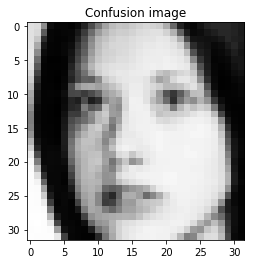

neighbour (747, 10)


ValueError: cannot reshape array of size 747 into shape (32,32)

In [13]:
from scipy import spatial as sp
from sklearn import metrics as skm


if __name__ == "__main__":
    
    init = tf.global_variables_initializer()
    sessMain = tf.InteractiveSession()
    sessMain.run(init)
    #q1()
    q2Task(0)
    q2Task(1)
    
    
    
    



        

## Loss on Q2 task 0 KNN

|k | 1 | 5 | 10 | 25| 50 | 100 | 200 | 
|------|------|-----|-----|-----|-----|-----|
|train | 0.0 | 0.85352 | 1.2578 | 1.4775 | 1.8555 | 2.1035| 2.584 |
|test | 0.9248 | 0.78516 | 0.88184 | 1.043 | 1.376 |1.9893| 2.6875|
|valid | 1.1631 | 1.3154 | 1.5439 | 1.5273 | 1.4131 |1.9678| 2.7832|




|k | 1 | 5 | 10 | 25| 50 | 100 | 200 | 
|------|------|-----|-----|-----|-----|-----|
|train | 0.0 | 0.046844 | 0.048859 | 0.083679 | 0.088379 | 0.10913 | 0.13721 |
|test |0.037628 | 0.048401 | 0.053772 | 0.059143 | 0.069885 | 0.069885 | 0.11292 |
|valid | 0.043488 | 0.043488 | 0.054352 | 0.04892 | 0.054352 | 0.070679 | 0.1087 |


loss train [0.0, 0.046844, 0.048859, 0.083679, 0.088379, 0.10913, 0.13721]
loss test [0.037628, 0.048401, 0.053772, 0.059143, 0.069885, 0.069885, 0.11292]



## Loss on Q2 task 0 KNN

k | 1 | 5 | 10 | 25 | 50 | 100 | 200 
--- | --- | --- | --- | --- | --- | --- | ---
train | 0.0 | 0.85352 | 1.2578 | 1.4775 | 1.8555 | 2.1035 | 2.584 
test | 0.9248 | 0.78516 | 0.88184 | 1.043 | 1.376 | 1.9893 | 2.6875
valid | 1.1631 | 1.3154 | 1.5439 | 1.5273 | 1.4131 | 1.9678| 2.7832

## Loss on Q2 task 1 KNN
k | 1 | 5 | 10 | 25 | 50 | 100 | 200 
--- | --- | --- | --- | --- | --- | --- | ---
train | 0.0 | 0.046844 | 0.048859 | 0.083679 | 0.088379 | 0.10913 | 0.13721 |
test | 0.037628 | 0.048401 | 0.053772 | 0.059143 | 0.069885 | 0.069885 | 0.11292 |
valid | 0.043488 | 0.043488 | 0.054352 | 0.04892 | 0.054352 | 0.070679 | 0.1087 |


# Loss representation in indicator function instead of squared difference
## Loss on Q2 task 0 KNN


note: total dim | train 747 | valid 92 | test 94 |


k | 1 | 5 | 10 | 25 | 50 | 100 | 200 
--- | --- | --- | --- | --- | --- | --- | ---
train | 0 | 148 | 206 | 253 | 308 | 358 | 428
test | 27 | 29 | 31 | 32 | 39 | 47 | 56
valid | 31 | 36 | 39 | 37| 39 | 48 | 63

## Loss on Q2 task 1 KNN
k | 1 | 5 | 10 | 25 | 50 | 100 | 200 
--- | --- | --- | --- | --- | --- | --- | ---
train |  0 | 70| 73 | 125 | 132 | 163 | 205
test |  7 | 9 | 10 | 11 | 13 | 13 | 21 
valid | 8 | 8 | 10 | 9 | 10 | 13 | 20